
# Delay time distributions

This notebook creates the delay time distribution Figures in Fishbach & van Son
Fig. 1 (split by channel) and Fig 7 (split by metallicity). 

The data used in these Figures can be found on [10.5281/zenodo.7080725](https://zenodo.org/record/7080725), and [10.5281/zenodo.7080164](https://zenodo.org/record/7080164).

For your convenience, this notebook saves the output needed to make the figures.  



In [1]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm
import os
from scipy import stats

# Import functions
import importlib
import SupportFunctions as func
importlib.reload(func)


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Delay time distribution for different physics variations
### In $\mathrm{d}t_{\mathrm{delay}}$ and $\mathrm{d}\log_{10}t_{\mathrm{delay}}$



## First collect and save all the data

In [9]:

def process_simulation_data(simulation_path, bin_by_log_tdelay):
    # Get data
    merging_BBH, Average_SF_mass_needed = func.get_essential_data(File_location=simulation_path + '/output/COMPAS_Output_wWeights.h5')

    # Calculate the delay time in Gyr and log10 of the delay time in Gyr
    merging_BBH['tDelayGyr'] = merging_BBH['tDelay'] * 1e-3
    merging_BBH['log_tDelayGyr'] = np.log10(merging_BBH['tDelayGyr'])

    # Define delay time bins based on the chosen mode
    if bin_by_log_tdelay:
        delay_time_bins = np.arange(-3, 2, 0.2)
        x_key = 'log_tDelayGyr'
        log_save_str = '_LOG'
    else:
        delay_time_bins = 10**np.arange(-3, 2, 0.2)
        x_key = 'tDelayGyr'
        log_save_str = ''

    table = merging_BBH
    WEIGHTS = merging_BBH['mixture_weight']

    # Define low and high metallicity
    LOW_Z, HIGH_Z = 0.014 / 10.0, 0.014 / 2.0
    lowZbool = table['Metallicity@ZAMS(1)'] <= LOW_Z
    midZbool = np.logical_and(table['Metallicity@ZAMS(1)'] > LOW_Z, table['Metallicity@ZAMS(1)'] <= HIGH_Z)
    highZbool = table['Metallicity@ZAMS(1)'] > HIGH_Z

    # Bools and labels to split by stable RLOF vs CE channel and by metallicity
    Bool_list = [np.full(len(table), True), table['CE_Event_Count'] > 0, table['CE_Event_Count'] == 0,
                 lowZbool, midZbool, highZbool]
    headers = ["All_xvalues", "All_yvalues", "CE_xvalues", "CE_yvalues", "stable_xvalues", "stable_yvalues",
               "lowZ_xvalues", "lowZ_yvalues", "midZ_xvalues", "midZ_yvalues", "highZ_xvalues", "highZ_yvalues"]

    data_list = None
    for i, Bool in enumerate(Bool_list):
        # Hist the data
        hist, bin_edge = np.histogram(table[x_key][Bool], weights=WEIGHTS[Bool], bins=delay_time_bins)
        center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.0
        binwidth = np.diff(delay_time_bins)

        # Save the hist data
        x_values = center_bins
        y_values = hist / binwidth * (10**6 / Average_SF_mass_needed.value)
        variation_data = np.column_stack((x_values, y_values))
        if i == 0:
            # Initialize the data_list with the first variation
            data_list = variation_data
        else:
            # Concatenate the variation data horizontally
            data_list = np.hstack((data_list, variation_data))

    # Save the data
    output_file = f'../Output/histogram_data_{os.path.basename(simulation_path)}{log_save_str}.csv'
    with open(output_file, 'w', newline='') as f:
        np.savetxt(f, data_list, delimiter=',', header=','.join(headers))

################################################################################################
# Decide wether you want to bin your data by t_delay or log10(t_delay), == change of variables
bin_by_log_tdelay = False
# Replace with the actual data path. Download data here: https://zenodo.org/record/7080725, and here: https://zenodo.org/record/7080164
data_location   = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/' # "/path/to/data"  
################################################################################################

# Loop over all simulations in this folder
for s, sim in enumerate(os.listdir(data_location)):
    if sim not in ['EssentialData', 'Grid_Call_Stroopwafel.py']:
        simulation_path = os.path.join(data_location, sim)
        # Check if the output file exists before running process_simulation_data
        output_file = f'../Output/histogram_data_{os.path.basename(simulation_path)}_LOG.csv'
        if not os.path.exists(output_file):
            print('collecting data for', output_file)
            process_simulation_data(simulation_path, bin_by_log_tdelay)

        else:
            print(output_file, 'already exists, skipping file')
            continue



../Output/histogram_data_faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix0.5SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix1.4SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccTHERMALzetaHG6.5RemMassFRYER2012SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.25zetaHG6.0RemMassFRYER2012SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.5gammaMIXTUREfcircum0.0zetaHG6.0RemMassFRYER2012SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.5zetaHG4.5RemMassFRYER2012SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix1.0SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix4.0SNDELAYED_LOG.csv already exists, skipping file
../Output/histogram_data_faccFIXEDbeta0.75

# Figure 1, delay time distribution split by channel

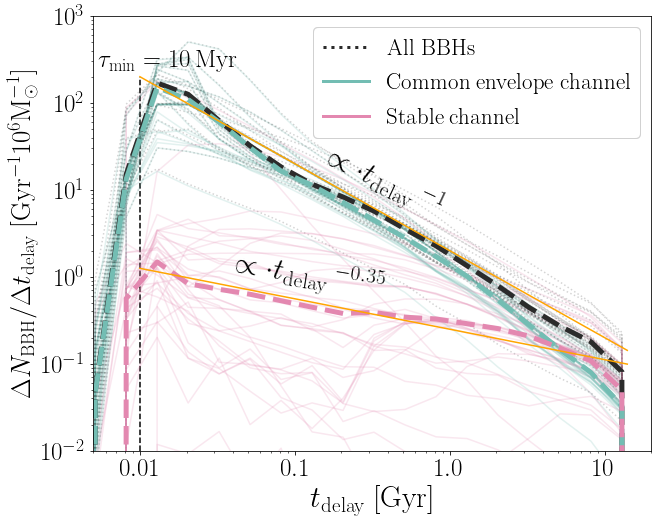

In [22]:

def plot_delay_time_distributions(logx=False):
    colors = ['#2b2b2b', '#73bdb3', '#e388b0']
    already_labelled = False
    labels = ['$\mathrm{All \ BBHs}$', '$\mathrm{Common \ envelope \ channel}$', '$\mathrm{Stable \ channel}$']
    
    # Lists for data to compute median values
    All_data = []
    CE_data = []
    Stable_data = []
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for s, outputName  in enumerate(os.listdir('../Output/') ):
        ####################
        # Get data
        if logx: # Assuming you've provided bin in logx!
            log_save_str    = '_LOG'
            if log_save_str not in outputName:
                continue
        else:
            log_save_str    = ''
            if '_LOG' in outputName:
                continue

        data = np.loadtxt('../Output/'+outputName, delimiter=',', skiprows=1)

        #########################################
        if already_labelled:
            labels = [None, None, None]

        # Plot the Histogram    
        ax.plot(data[:, 0], data[:, 1], alpha=0.2,  color=colors[0], lw = 1.5, label = labels[0], ls = ':') 
        ax.plot(data[:, 2], data[:, 3], alpha=0.2,  color=colors[1], lw = 1.5, label = labels[1], ls = '-') 
        ax.plot(data[:, 4], data[:, 5], alpha=0.2,  color=colors[2], lw = 1.5, label = labels[2], ls = '-') 

        already_labelled = True

        # Collect data for medium 
        All_data.append(data[:, 1])
        CE_data.append(data[:, 3])
        Stable_data.append(data[:, 5])

        if logx: # Assuming you've provided bin in logx!
            x_lim, y_lim = (-2.5, np.log10(20)), (1e-2,100)
        else:
            x_lim, y_lim = (5e-3,20), (1e-2,1e3)
            ax.set_xscale('log')
            plt.xticks([1e-2, 1e-1, 1e0, 1e1], ['$0.01$', '$0.1$', '$1.0$','$10$'] )

    legend1 = plt.legend(fontsize = 23, loc  = 'upper right')
    # set the linewidth of each legend object
    for legobj in legend1.legendHandles:
        legobj.set_linewidth(3.0)
        legobj.set_alpha(1)
    plt.gca().add_artist(legend1)


    #########################################
    # Plot the median lines
    All_median    = np.median(np.vstack(All_data), axis=0)
    CE_median     = np.median(np.vstack(CE_data), axis=0)
    Stable_median = np.median(np.vstack(Stable_data), axis=0)

    ax.plot(data[:, 0], All_median, color=colors[0], linestyle='dashed', linewidth=5, label = None)
    ax.plot(data[:, 0], CE_median, color=colors[1], linestyle='dashed', linewidth=5, label = None)
    ax.plot(data[:, 0], Stable_median, color=colors[2], linestyle='dashed', linewidth=5, label = None)


    ##########################################
    # # ANALYTICAL ESTIMATIONS 
    if logx: 
        x = np.arange(-2, 1.2, step = 0.1)
        colors = ['k' ,'#02a342',  '#d01c8b']

        lin2 =plt.plot(x, 3*10**(0*x), c = 'orange', lw = 1.5, ls = '-')
        plt.text(-1.2, 5, '$\propto t_{\mathrm{delay}}\,^{0}$',c = 'k', size = 30, rotation = -1)

        lin3 =plt.plot(x, 0.5*10**(0.65*x), c = 'orange', lw = 1.5, ls = '-')
        plt.text(-1.5, 0.1, '$\propto t_{\mathrm{delay}}\,^{0.65}$',c = 'k', size = 30, rotation = 20)

        # Show tau min 20 Myr = 20*1e-3 Gyr 
        plt.vlines(np.log10(1e-2), color = 'k', ymin = 1e-2, ymax = 9, lw = 3, ls = '-')
        plt.text(np.log10(0.01), 1.25*9, r'$\tau_\mathrm{min} = 10 \, \mathrm{Myr}$',c = 'k', size = 20, ha = 'center')

    else:
        x = np.logspace(-2, np.log10(14))
        colors = ['k' ,'#d01c8b',  '#d01c8b']

        lin1 = plt.plot(x, 2*x**-1, c = 'orange', lw = 1.5)
        plt.text(0.15, 5, '$\propto \cdot t_{\mathrm{delay}}\,^{-1}$',c = 'k', size = 30, rotation = -25)

        lin3 = plt.plot(x, 0.25*x**-0.35, c = 'orange', lw = 1.5, ls = '-')
        plt.text(0.04, 0.6, '$\propto \cdot t_{\mathrm{delay}}\,^{-0.35}$',c = 'k', size = 30, rotation = -9)

        # Show tau min 20 Myr = 20*1e-3 Gyr 
        plt.vlines(1e-2, color = 'k', ymin = 1e-2, ymax = 200, lw = 1.5, ls = '--')
        plt.text(0.015, 200*1.3, r'$\tau_\mathrm{min} = 10 \, \mathrm{Myr}$',c = 'k', size = 25, ha = 'center')
        
    #########################################
    # plot values
    ax.set_yscale('log')
    y_ticks = ax.get_yticks()
    
    ax.set_xlim(x_lim[0], x_lim[-1])
    ax.set_ylim(y_lim[0], y_lim[-1])

    if logx:
        ax.set_xlabel('$\log_{10}( t_{\mathrm{delay} } ) \ \mathrm{[Gyr]}$', fontsize=30)
        ax.set_ylabel(r'$\Delta N_{\mathrm{BBH}}/ \Delta \log_{10} t_{\mathrm{delay}} \ \mathrm{[Gyr^{-1} 10^6 M_{\odot}^{-1} ] }$', fontsize=27)
    else:
        ax.set_xlabel('$ t_{\mathrm{delay} } \ \mathrm{[Gyr]}$', fontsize=30)
        ax.set_ylabel(r'$\Delta N_{\mathrm{BBH}}/ \Delta t_{\mathrm{delay}} \ \mathrm{[Gyr^{-1} 10^6 M_{\odot}^{-1} ] }$', fontsize=27)

    plt.savefig('../Figures/delaytime_distributions_tdelay' + log_save_str + '.pdf', bbox_inches='tight')
    plt.show()


###################################################################
logx = False
plot_delay_time_distributions(logx)


# Fig. 7 Split by metallicity

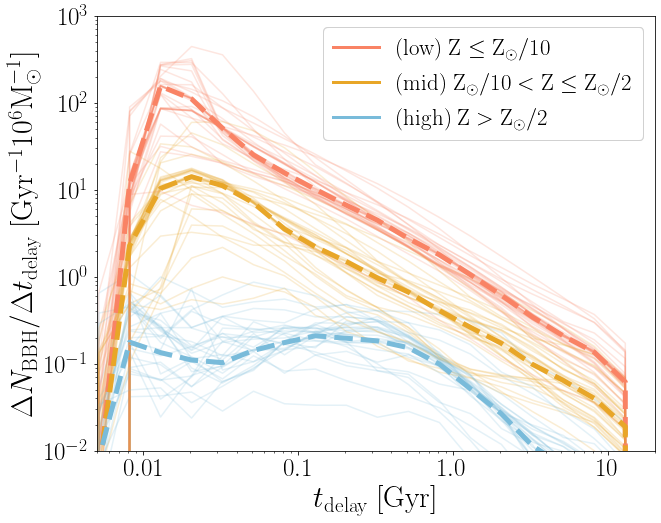

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metal_delay_time_distributions(logx=False):
    colors = ['#f98365', '#e8a628', '#79BBDA']
    already_labelled = False
    labels = ['$\mathrm{(low) \ Z \leq Z_{\odot}/10}$', '$\mathrm{(mid) \ Z_{\odot}/10 < Z \leq Z_{\odot}/2}$', '$\mathrm{(high) \ Z > Z_{\odot}/2}$']

    low_metallicity_data = []
    medium_metallicity_data = []
    high_metallicity_data = []

    fig, ax = plt.subplots(figsize=(10, 8))

    # loop over all simulations in this folder
    for s, outputName  in enumerate(os.listdir('../Output/') ):

        ####################
        # Get data
        if logx: # Assuming you've provided bin in logx!
            log_save_str    = '_LOG'
            if log_save_str not in outputName:
                continue
        else:
            log_save_str    = ''
            if '_LOG' in outputName:
                continue

        data = np.loadtxt('../Output/'+outputName, delimiter=',', skiprows=1)

        #########################################
        # Bools and labels to split by stable RLOF vs CE channel
        if already_labelled:
            labels = [None, None, None]

        # Plot the Hist    
        ax.plot(data[:, 6], data[:, 7], alpha=0.2,  color=colors[0], lw = 1.5, label = labels[0]) 
        ax.plot(data[:, 8], data[:, 9], alpha=0.2,  color=colors[1], lw = 1.5, label = labels[1]) 
        ax.plot(data[:, 10], data[:, 11], alpha=0.2,  color=colors[2], lw = 1.5, label = labels[2]) 
        #ax.step(data[:, 6 + i*2], data[:, 7 + i*2],where='mid', alpha=0.25,  color=colors[i], lw = 2, label = LAB) 

        already_labelled = True

        if logx: # Assuming you've provided bin in logx!
            x_lim, y_lim = (-2.3, np.log10(20)), (1e-2,100)
        else:
            x_lim, y_lim = (5e-3,20), (1e-2,1e3)
            ax.set_xscale('log')
            plt.xticks([1e-2, 1e-1, 1e0, 1e1], ['$0.01$', '$0.1$', '$1.0$','$10$'] )

        # Collect data for medium metallicity
        low_metallicity_data.append(data[:, 7])
        medium_metallicity_data.append(data[:, 9])
        high_metallicity_data.append(data[:, 11])

    legend1 = plt.legend(fontsize = 23, loc  = 'upper right')
    # set the linewidth of each legend object
    for legobj in legend1.legendHandles:
        legobj.set_linewidth(3.0)
        legobj.set_alpha(1)
    plt.gca().add_artist(legend1)

    low_median = np.median(np.vstack(low_metallicity_data), axis=0)
    medium_median = np.median(np.vstack(medium_metallicity_data), axis=0)
    high_median = np.median(np.vstack(high_metallicity_data), axis=0)

    ax.plot(data[:, 6], low_median, color=colors[0], linestyle='dashed', linewidth=5, label='Median (low)')
    ax.plot(data[:, 6], medium_median, color=colors[1], linestyle='dashed', linewidth=5, label='Median (medium)')
    ax.plot(data[:, 6], high_median, color=colors[2], linestyle='dashed', linewidth=5, label='Median (high)')

    ax.set_yscale('log')
    y_ticks = ax.get_yticks()

    ax.set_xlim(x_lim[0], x_lim[-1])
    ax.set_ylim(y_lim[0], y_lim[-1])

    if logx:
        ax.set_xlabel('$\log_{10}( t_{\mathrm{delay} } ) \ \mathrm{[Gyr]}$', fontsize=30)
        ax.set_ylabel(r'$\Delta N_{\mathrm{BBH}}/ \Delta \log_{10} t_{\mathrm{delay}} \ \mathrm{[Gyr^{-1} 10^6 M_{\odot}^{-1} ] }$', fontsize=30)
    else:
        ax.set_xlabel('$ t_{\mathrm{delay} } \ \mathrm{[Gyr]}$', fontsize=30)
        ax.set_ylabel(r'$\Delta N_{\mathrm{BBH}}/ \Delta t_{\mathrm{delay}} \ \mathrm{[Gyr^{-1} 10^6 M_{\odot}^{-1} ] }$', fontsize=30)

    plt.savefig('../Figures/Metal_delaytime_distributions_tdelay' + log_save_str + '.pdf')
    plt.show()


logx = False
plot_metal_delay_time_distributions(logx)
